## <center> *Python based exercises for*</center>
# <center> Introduction to analysis and inversion of <br> SEISMOLOGICAL DATA </center>

lecturer : Nikolai Shapiro <br>
email: nikolai.shapiro@univ-grenoble-alpes.fr<br>
<br>
Main textbook for the class: [An Introduction to Seismology, Earthquakes, and Earth Structure (Stein and Wysession)](http://levee.wustl.edu/seismology/book/)

## Main Python packages used: 

- [**ObsPy**](https://github.com/obspy/obspy/wiki) : for downloading and basic analysis of seismic data

- [**NumPy**](https://numpy.org) : for mathematical functions

- [**Matplotlib**](https://matplotlib.org) : for plotting results

---

## Exercises to illustrate estimations of magnitude ans seismic moment from seismograms


---

## Step 1: Downloading waveforms and converting into displacement in microns

(ObsPy [*remove_response*](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html#obspy.core.trace.Trace.remove_response) function)

---
Map of [Southern California Seismic Netowork CI](https://www.fdsn.org/networks/detail/CI/) with highligtet CGO station and approximately indicated 
location of an earthquake in Nevada

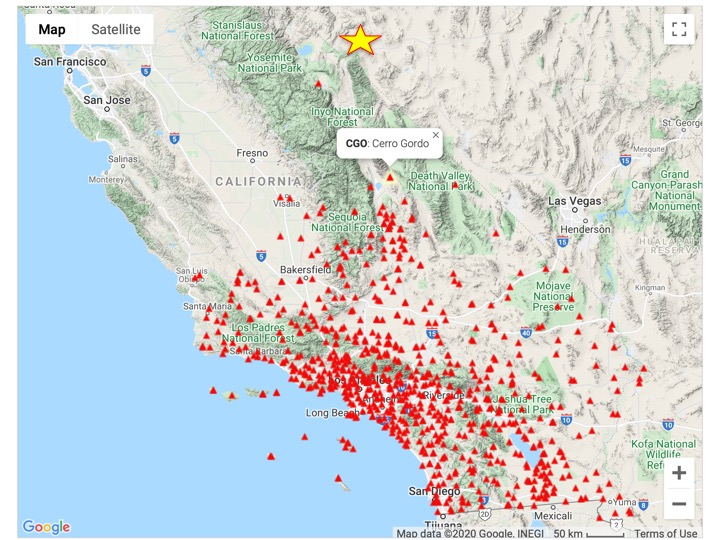

---

In [ ]:
#------------------------ importing basic packages
import matplotlib.pyplot as plt
import numpy as np
#------------------------ importing ObsPy functions
import obspy
from obspy import read
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

#------------------ plotting mode
%matplotlib widget
#----------------------------


#-------- epicenter coordinates
evla = 38.169                # earthquake 1 to test
evlo = -117.85

#evla2 = 38.201                # earthquake 2 to test
#evlo2 = -117.745




#------------------------ selecting an FDSN datacenter 
client = Client('SCEDC')
#------------------------ selecting network, station, channel
ntw = "CI"

sta = "CGO"
#sta = "DAW"
#sta = "SPG2"
#sta = "CAR"
#sta = "SMM"
#sta = "SLA"
#sta = "BAR"

chn = "HH*"




#-------------------- defining duration of the downloaded time series in sec
t_duration = 10*60


#------------ origin and location time of earthquake  -------
tstart = UTCDateTime("2020-05-15T11:03:27.000")                 # earthquake 1 to test
#tstart = UTCDateTime("2020-05-20T12:36:53.000")                 # earthquake 2 to test


#------------- onset before the earthquake starting time (sec)
tshift = -100


#-----------  getting station inventory (to know coordinates)
inv = client.get_stations(network=ntw, station=sta,  starttime=tstart+tshift, endtime=tstart+tshift + t_duration, channel="HHN", includeavailability=True)


#------------  getting waveforms
st1 = client.get_waveforms(ntw, sta, "*", chn, tstart+tshift, tstart+tshift + t_duration, attach_response=True)


#------------ detrending time series
st1.detrend()

#-------------- extracting a trace from the stream
s1 = st1[0]




#--------- adding coordinates to the trace header
s1.stats.stla = inv[0][0].latitude
s1.stats.stlo = inv[0][0].longitude
s1.stats.evla = evla
s1.stats.evlo = evlo
dst = obspy.geodetics.base.gps2dist_azimuth(s1.stats.stla,s1.stats.stlo,s1.stats.evla,s1.stats.evlo)
s1.stats.dist = dst[0]/1000.


#----------- printing information in the header (trace.stats)
print("network: ", s1.stats.network)
print("station: ", s1.stats.station)

print("start time: ", s1.stats.starttime)


print("station latitude: ", s1.stats.stla)
print("station longitude: ", s1.stats.stlo)

print("event latitude: ", s1.stats.evla)
print("event longitude: ", s1.stats.evlo)

print("epicentral distance (km): ", s1.stats.dist)

print("component: ", s1.stats.channel)
print("discretization time step: ", s1.stats.delta)
print("number of samples: ", s1.stats.npts)




#------------------ correcting for instrument response
pre_filt = (0.0003, 0.005, 30.0, 35.0)                   # defining spectral band
st1.remove_response(output='DISP', pre_filt=pre_filt)

#------------------------- converting to microns
st1[0].data = st1[0].data*1e6
st1[1].data = st1[1].data*1e6
st1[2].data = st1[2].data*1e6


#------------- tapering the trace to remove edge effects
st1.taper(0.01)

#-------- plotting corrected displacement seismogram
dt = st1[0].stats.delta
npts = st1[0].stats.npts
time0 = dt*(np.linspace(1,npts,npts)-1) + tshift

dt = st1[1].stats.delta
npts = st1[1].stats.npts
time1 = dt*(np.linspace(1,npts,npts)-1) + tshift

dt = st1[2].stats.delta
npts = st1[2].stats.npts
time2 = dt*(np.linspace(1,npts,npts)-1) + tshift



#------------------------------------------- plotting 3 displacement seismograms
fig, axs = plt.subplots(3, 1, sharex=True)
fig.subplots_adjust(hspace=0)

fig.suptitle(st1[0].stats.starttime.ctime() + '     ' + st1[0].stats.station + '   displacement')

axs[0].plot(time0, st1[0].data)
axs[0].set_title(st1[0].stats.channel,loc='right', y=0.8)

axs[1].plot(time1, st1[1].data)
axs[1].set_title(st1[1].stats.channel, loc='right', y=0.8)
axs[1].set_ylabel("ground displacement (microns)")

axs[2].plot(time2, st1[2].data)
axs[2].set_title(st1[2].stats.channel, loc='right', y=0.8)
axs[2].set_xlabel('time (s)')

plt.show()
#-------------------

---

## Step 2: Filtering

ObsPy [*filter*](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.filter.html) function.


### This high-pass filering is applied to obtain a signal approximately corresponding to **Wood-Anderson** seismometer
---

In [ ]:
#------------------------ importing basic packages
import matplotlib.pyplot as plt
import numpy as np
#------------------------ importing ObsPy functions
from obspy import read

#------------------ plotting mode
%matplotlib widget
#----------------------------

st1hf = st1.copy()

st1hf.filter("highpass", freq=0.8, corners=4, zerophase=True)

s1hf = st1hf[0]


#------------------------------------------- plotting 3 displacement seismograms
fig, axs = plt.subplots(3, 1, sharex=True)
fig.subplots_adjust(hspace=0)

fig.suptitle(st1[0].stats.station + '   displacement highpassed 1 Hz')

axs[0].plot(time0, st1hf[0].data)
axs[0].set_title(st1hf[0].stats.channel,loc='right', y=0.8)

axs[1].plot(time1, st1hf[1].data)
axs[1].set_title(st1hf[1].stats.channel, loc='right', y=0.8)
axs[1].set_ylabel("ground displacement (microns)")

axs[2].plot(time2, st1hf[2].data)
axs[2].set_title(st1hf[2].stats.channel, loc='right', y=0.8)
axs[2].set_xlabel('time (s)')

plt.show()
#-------------------


---

## Step 3: Estimating the magnitude $M_l$

$$M_l = \log A + 2.76 \log \Delta - 2.48$$

where $A$ is the maximum displacement ampitude (in microns) recorded by a **Wood-Anderson** seismometer and $\Delta$ is the epicentral distance in kilometers.

$A$ can be **approximately** estimated as the maximum amplitude of high-pass filtered displacement seismogram

Use the previous Figure to estimate $A$ and the equation above to compute magnitude

---

In [ ]:
#---------- write the value of maximal amplitude here
AMAX = 0.58


#-------------------------- Ml from estimated maximal ampitude
Ml = np.log10(AMAX) + 2.76*np.log10(s1.stats.dist) - 2.48

print("station ", s1.stats.station)
print("epicentral distance (km): ", s1.stats.dist)
print("high frequency Amplitude: (microns)", AMAX)
print("Ml estimation: ", Ml)

---

## Step 4: Computing displacement amplitude spectra. Estimating seismic moment and corner frequency  

We assume that the dominant part of the signal is the S-wave (**!!! approximation 1**).

Then, we use an expression for the S-wave far-field term in a homogeneous space (**!!! approximation 2**) and ignore the anelastic attenuation (**!!! approximation 3**) and the radiation pattern (**!!! approximation 4**).

Amplitude Fourier spectra is computed and multiplied by the normalization factor of the far-field S-waves (Aki & Richards, eq. 4.29) :

$$norm_S = 4 \pi \rho \beta^3 \Delta$$

where $\rho$ is the densisty, $\beta$ is the S-wave speed, and $\Delta$ is the epicentral distance (all in international units).

If a "plateau" is observed in the low-frequency end of the spectra. The seismic moment $M_0$ can be estimated as average within of this plateau. The corner frequency $f_c$ can be estimated as the crossing between this plateau and the $\omega^{-2}$ decay (slope indicated with dashed line) 

---

In [ ]:
#------------------------ importing basic packages
import matplotlib.pyplot as plt
import numpy as np

#------------------ plotting mode
%matplotlib widget
#----------------------------

#-----------------------------------------------
# function to compute Fourier spectra
#-----------------------------------------------
def signal_fft1d(sig,dt):
    npt = np.size(sig)
    spe = np.fft.fft(sig)
    freq = np.fft.fftfreq(npt,dt)
    sp_amp = np.sqrt(spe.real**2+spe.imag**2)
    sp_pha = np.arctan2(spe.imag, spe.real)
    npt_spe = int(npt/2)
    return npt_spe, dt*sp_amp[0:npt_spe],sp_pha[0:npt_spe],freq[0:npt_spe]


#----------- defining S-wave far field normalization factor
rho = 2800
Vs = 3600
moment_norm = 4*np.pi*rho*Vs**3*s1.stats.dist*1000.
mref = 4*np.pi*rho*Vs**3*180.*1000.




#-------------------------------- renormalizing the signal (after re-converting to meters)
sig1 = moment_norm*st1[0].data/1e6
#----------- Fourier transform
nspe, spamp, sppha, fr = signal_fft1d(sig1,s1.stats.delta)
#-------------- plotting
plt.figure()
plt.loglog(fr,spamp)
plt.loglog([.12,12],[mref*.03,mref*.000003],'k:')
plt.xlim(.05,10)
plt.ylim(7.e14,5.e19)
plt.xlabel('frequency(Hz)')
plt.ylabel('seismic moment (N m)')
plt.title(s1.stats.station + ' ' + st1[0].stats.channel + '   ' + str(s1.stats.starttime))
plt.show()

#-------------------------------- renormalizing the signal (after re-converting to meters)
sig1 = moment_norm*st1[1].data/1e6
#----------- Fourier transform
nspe, spamp, sppha, fr = signal_fft1d(sig1,s1.stats.delta)
#-------------- plotting
plt.figure()
plt.loglog(fr,spamp)
plt.loglog([.12,12],[mref*.03,mref*.000003],'k:')
plt.xlim(.05,10)
plt.ylim(7.e14,5.e19)
plt.xlabel('frequency(Hz)')
plt.ylabel('seismic moment (N m)')
plt.title(s1.stats.station + ' ' + st1[1].stats.channel + '   ' + str(s1.stats.starttime))
plt.show()

#-------------------------------- renormalizing the signal (after re-converting to meters)
sig1 = moment_norm*st1[2].data/1e6
#----------- Fourier transform
nspe, spamp, sppha, fr = signal_fft1d(sig1,s1.stats.delta)
#-------------- plotting
plt.figure()
plt.loglog(fr,spamp)
plt.loglog([.12,12],[mref*.03,mref*.000003],'k:')
plt.xlim(.05,10)
plt.ylim(7.e14,5.e19)
plt.xlabel('frequency(Hz)')
plt.ylabel('seismic moment (N m)')
plt.title(s1.stats.station + ' ' + st1[2].stats.channel + '   ' + str(s1.stats.starttime))
plt.show()






---

## Step 5:  Estimating [moment magnitude](https://en.wikipedia.org/wiki/Moment_magnitude_scale) $M_w$ 

The moment magnitude is than estimated with the Hanks and Kanamori (1979) formula:

$$M_w = (\log M_0 - 9.05)/1.5$$

---

In [ ]:
#------ write the value of seismic moment here
M0 = 8e16

#------ write the value of corner frequency
fc = 0.41

#---------------------------- computing moment magnitude
Mw =(np.log10(M0)-9.05)/1.5


print("station ", s1.stats.station)
print("epicentral distance (km): ", s1.stats.dist)
print("high frequency Amplitude: (microns)", AMAX)
print("Ml estimation: ", Ml)
print("seismic moment (N m): ", M0)
print("corner frequency (Hz): ", fc)
print("moment magnitude estimation Mw: ", Mw)

#---------------- output for plotting
print(' ')
print('------------ output for plotting')
print('#' + s1.stats.station)
print('dist.append(',s1.stats.dist,')')
print('AMAX.append(',AMAX,')')
print('Ml.append(',Ml,')')
print('M0.append(',M0,')')
print('fc.append(',fc,')')
print('Mw.append(',Mw,')')